<a href="https://colab.research.google.com/github/Wilkingc/ddc-datascience/blob/main/Song_Prediction_4_Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Low RMSE Song Prediction

- Wilking Chali Alphonse 11/05/2024

## Problem definition

This project will take data features collected for songs that have been on the Top 200 Weekly (Global) charts of Spotify in 2020 & 2021. The popularity of the song will be predicted using a tree-based regression model trained on these features.

The goals for the project are:

Minimize the cross-validated root mean squared error ( RMSE ) when predicting the popularity of a new song.

Determine the most important features for a future song.

## Data collection / Source

This data comes from: https://ddc-datascience.s3.amazonaws.com/Projects/Project.4-Spotify/Data/Spotify.csv.


## Imports

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

from dateutil.parser import parse
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import graphviz
from IPython.display import display
from IPython.display import Image
from sklearn import tree
import pickle
from sklearn.preprocessing import LabelEncoder
import sqlite3

## File path & read the data

In [2]:
url = "https://ddc-datascience.s3.amazonaws.com/Projects/Project.4-Spotify/Data/Spotify.csv" # Using bash command to pull the data to our notebook.
!curl -s -I {url}

HTTP/1.1 200 OK
x-amz-id-2: 3IvDQQWt/34ll25/K9SuMALNIGUA9NSIZWLP7Nivh7ZLcxgyWgiVwrau1OvDykUgVZtscSUTTig=
x-amz-request-id: XJN8DSB6Z7VNG6H5
Date: Tue, 05 Nov 2024 15:17:02 GMT
Last-Modified: Wed, 04 Oct 2023 17:23:56 GMT
ETag: "65b9875b11e0d7ea03ee2af024f45e99"
x-amz-server-side-encryption: AES256
Accept-Ranges: bytes
Content-Type: text/csv
Server: AmazonS3
Content-Length: 738124



In [3]:
spotify = pd.read_csv(url) # Reading the data into the variable Spotify

In [4]:
pd.set_option('display.max_columns', None) # We are using this method to display all the columns in our dataset.

In [5]:
spotify.head()

,Index,Highest Charting Position,Number of Times Charted,Week of Highest Charting,Song Name,Streams,Artist,Artist Followers,Song ID,Genre,Release Date,Weeks Charted,Popularity,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,Chord
0,1,1,8,2021-07-23--2021-07-30,Beggin',"48,633,449",Måneskin,3377762,3Wrjm47oTz2sjIgck11l5e,"['indie rock italiano', 'italian pop']",2017-12-08,2021-07-23--2021-07-30\n2021-07-16--2021-07-23...,100,0.714,0.8,-4.808,0.0504,0.127,0.359,134.002,211560,0.589,B
1,2,2,3,2021-07-23--2021-07-30,STAY (with Justin Bieber),"47,248,719",The Kid LAROI,2230022,5HCyWlXZPP0y6Gqq8TgA20,['australian hip hop'],2021-07-09,2021-07-23--2021-07-30\n2021-07-16--2021-07-23...,99,0.591,0.764,-5.484,0.0483,0.0383,0.103,169.928,141806,0.478,C#/Db
2,3,1,11,2021-06-25--2021-07-02,good 4 u,"40,162,559",Olivia Rodrigo,6266514,4ZtFanR9U6ndgddUvNcjcG,['pop'],2021-05-21,2021-07-23--2021-07-30\n2021-07-16--2021-07-23...,99,0.563,0.664,-5.044,0.154,0.335,0.0849,166.928,178147,0.688,A
3,4,3,5,2021-07-02--2021-07-09,Bad Habits,"37,799,456",Ed Sheeran,83293380,6PQ88X9TkUIAUIZJHW2upE,"['pop', 'uk pop']",2021-06-25,2021-07-23--2021-07-30\n2021-07-16--2021-07-23...,98,0.808,0.897,-3.712,0.0348,0.0469,0.364,126.026,231041,0.591,B
4,5,5,1,2021-07-23--2021-07-30,INDUSTRY BABY (feat. Jack Harlow),"33,948,454",Lil Nas X,5473565,27NovPIUIRrOZoCHxABJwK,"['lgbtq+ hip hop', 'pop rap']",2021-07-23,2021-07-23--2021-07-30,96,0.736,0.704,-7.409,0.0615,0.0203,0.0501,149.995,212000,0.894,D#/Eb


In [6]:
spotify.shape

(1556, 23)

In [7]:
spotify.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1556 entries, 0 to 1555
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Index                      1556 non-null   int64 
 1   Highest Charting Position  1556 non-null   int64 
 2   Number of Times Charted    1556 non-null   int64 
 3   Week of Highest Charting   1556 non-null   object
 4   Song Name                  1556 non-null   object
 5   Streams                    1556 non-null   object
 6   Artist                     1556 non-null   object
 7   Artist Followers           1556 non-null   object
 8   Song ID                    1556 non-null   object
 9   Genre                      1556 non-null   object
 10  Release Date               1556 non-null   object
 11  Weeks Charted              1556 non-null   object
 12  Popularity                 1556 non-null   object
 13  Danceability               1556 non-null   object
 14  Energy  

### Prepare the data for SQlite queries

In [8]:
# Using In-memory database (no separate file needed)
conn = sqlite3.connect(':memory:')

In [9]:
# Define our table name
table_music = 'spotify_data'

# Create the table (modify columns based on your data)
spotify.to_sql(table_music, conn, index=False)

1556

## Data Cleaning

Let's check for nulls

In [10]:
spotify.isnull().sum()# We don't have null but we have some discrepancy with the data structure of some columns

,0
Index,0
Highest Charting Position,0
Number of Times Charted,0
Week of Highest Charting,0
Song Name,0
Streams,0
Artist,0
Artist Followers,0
Song ID,0
Genre,0


We will drop the identifiers and other features that won't help our predictive model before proceeding with the data normalization.

- Most of these features describe the performance of previous songs once they were out for the public, but we want to use the features that we know for a fact we can use for a future song.

In [11]:
music = spotify.copy() # We are copying the dataset into the music variable

In [12]:
music.drop(['Index','Song ID','Weeks Charted','Week of Highest Charting','Song Name',
            'Popularity','Artist','Highest Charting Position','Number of Times Charted',
            'Release Date','Streams','Artist Followers'], axis = 1, inplace = True)

Let's check for whitespaces in our dataset

In [13]:
# Define the columns to check
columns_to_check = [
 'Genre',
 'Danceability',
 'Energy',
 'Loudness',
 'Speechiness',
 'Acousticness',
 'Liveness',
 'Tempo',
 'Duration (ms)',
 'Valence',
 'Chord']

# Function to check for whitespace
def check_whitespace(df, columns):
    for col in columns:
        if df[col].dtype == 'object':  # Check if column is string-based
            whitespace_rows = df[df[col].str.contains(r'\s+')].index
        else:  # Numeric column, check for spaces in string representation
            whitespace_rows = df[df[col].astype(str).str.contains(r'\s+')].index
        if not whitespace_rows.empty:
            print(f"Whitespace found in column '{col}' at rows:")
            print(whitespace_rows)
check_whitespace(music, columns_to_check)

Whitespace found in column 'Genre' at rows:
Index([   0,    1,    3,    4,    5,    6,    7,    8,    9,   10,
       ...
       1546, 1547, 1548, 1549, 1550, 1551, 1552, 1553, 1554, 1555],
      dtype='int64', length=1448)
Whitespace found in column 'Danceability' at rows:
Index([35, 163, 464, 530, 636, 654, 750, 784, 876, 1140, 1538], dtype='int64')
Whitespace found in column 'Energy' at rows:
Index([35, 163, 464, 530, 636, 654, 750, 784, 876, 1140, 1538], dtype='int64')
Whitespace found in column 'Loudness' at rows:
Index([35, 163, 464, 530, 636, 654, 750, 784, 876, 1140, 1538], dtype='int64')
Whitespace found in column 'Speechiness' at rows:
Index([35, 163, 464, 530, 636, 654, 750, 784, 876, 1140, 1538], dtype='int64')
Whitespace found in column 'Acousticness' at rows:
Index([35, 163, 464, 530, 636, 654, 750, 784, 876, 1140, 1538], dtype='int64')
Whitespace found in column 'Liveness' at rows:
Index([35, 163, 464, 530, 636, 654, 750, 784, 876, 1140, 1538], dtype='int64')
Whitespace 

Since we have empty spaces at the same index positions, we will drop all the rows with empty value.

In [14]:
music = music[~(music == ' ').any(axis=1)]

We have some categorical columns that should be numerical so we will turn them to numerical type.

In [15]:
to_int = ['Danceability','Energy','Loudness','Speechiness','Acousticness','Liveness','Tempo','Duration (ms)','Valence']

for col in to_int:
    music[col] = pd.to_numeric(music[col], errors='coerce')

<ipython-input-15-3c8e85ef155d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  music[col] = pd.to_numeric(music[col], errors='coerce')


Normalize the column Genre and find out the most common genres

In [16]:
common_genres = music['Genre'].str.replace(r"['\[\]]","", regex = True).str.strip(", ").str.split(", ").explode().value_counts()
common_genres #We can see that pop is the genre mostly listened to by consumers

,count
Genre,
pop,485
rap,310
dance pop,257
post-teen pop,256
pop rap,164
...,...
celtic,1
american folk revival,1
funk bh,1


### Integer Encoding

In [17]:
labelencoder = LabelEncoder() # Create an instance of labelencoder

music['Chord'] = labelencoder.fit_transform(music['Chord']) # Select the column to encode

Select just the numerical features

In [18]:
numeric_df = music.select_dtypes(include=['number']) # Defining the numeric_df variable and pulling the numerical columns

In [19]:
numeric_df.head()

,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,Chord
0,0.714,0.800,-4.808,0.0504,0.1270,0.3590,134.002,211560,0.589,2
1,0.591,0.764,-5.484,0.0483,0.0383,0.1030,169.928,141806,0.478,4
2,0.563,0.664,-5.044,0.1540,0.3350,0.0849,166.928,178147,0.688,0
3,0.808,0.897,-3.712,0.0348,0.0469,0.3640,126.026,231041,0.591,2
4,0.736,0.704,-7.409,0.0615,0.0203,0.0501,149.995,212000,0.894,6


## Q&A with SQL

What's the most popular song in our dataset?

In [20]:
query = f"SELECT * FROM {table_music} WHERE Popularity = 100"

# Execute the query and store the results in a DataFrame
results = pd.read_sql_query(query, conn)

# Display the results
display(results)

,Index,Highest Charting Position,Number of Times Charted,Week of Highest Charting,Song Name,Streams,Artist,Artist Followers,Song ID,Genre,Release Date,Weeks Charted,Popularity,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,Chord
0,1,1,8,2021-07-23--2021-07-30,Beggin',"48,633,449",Måneskin,3377762,3Wrjm47oTz2sjIgck11l5e,"['indie rock italiano', 'italian pop']",2017-12-08,2021-07-23--2021-07-30\n2021-07-16--2021-07-23...,100,0.714,0.8,-4.808,0.0504,0.127,0.359,134.002,211560,0.589,B


What's the average Danceability and Energy in our dataset?
- This is to compare it to the values of our most popular song.

In [21]:
query = f"SELECT AVG(Danceability), AVG(Energy) FROM {table_music}"

results = pd.read_sql_query(query, conn)
display(results)

,AVG(Danceability),AVG(Energy)
0,0.685119,0.629017


What's the Genre and Acousticness where the song popularity is greater than 60 point score?


- We can see that Pop is the most likeable genre for consumers.

In [22]:
query = f"SELECT Genre, Acousticness FROM {table_music} WHERE Popularity > 60 "

results = pd.read_sql_query(query, conn)
display(results.head())

,Genre,Acousticness
0,['australian hip hop'],0.0383
1,['pop'],0.335
2,"['pop', 'uk pop']",0.0469
3,"['lgbtq+ hip hop', 'pop rap']",0.0203
4,"['lgbtq+ hip hop', 'pop rap']",0.297


## EDA

We want to see the correlation between the features we have selected so far.

- We will be using the clean data stored in the variable numeric_df.

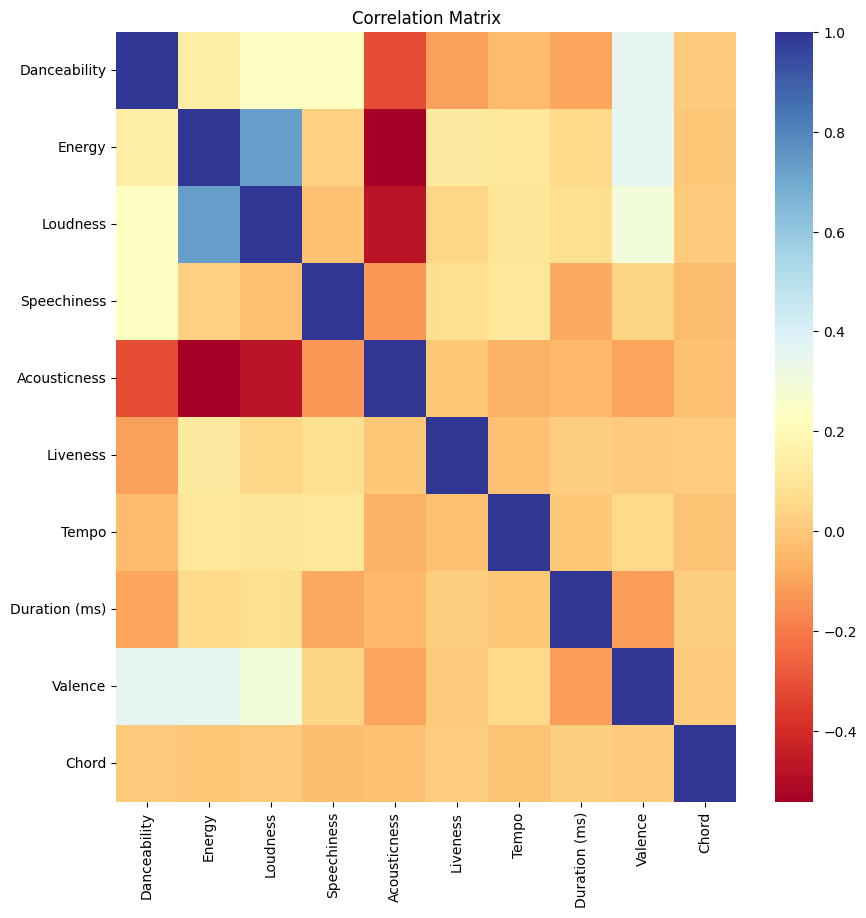

In [23]:
plt.figure(figsize=(10,10))
correlation_matrix = numeric_df.corr()
sns.heatmap(data=correlation_matrix, annot=False, cmap='RdYlBu') ;
plt.title("Correlation Matrix")
plt.show()

- Since we don't have a clear target and we have at least three features with close correlation with other features we will go with energy as our target.

In [24]:
corrs1 = numeric_df.corr().round(2).unstack().abs() # Here we stack the features and find the absolute values to select the necessary features for our model
corrs1 = corrs1[corrs1 <1]
corrs1.sort_values(ascending = False)

Loudness       Energy           0.73
Energy         Loudness         0.73
               Acousticness     0.54
Acousticness   Energy           0.54
Loudness       Acousticness     0.48
                                ... 
               Chord            0.01
Chord          Energy           0.00
Duration (ms)  Tempo            0.00
Energy         Chord            0.00
Tempo          Duration (ms)    0.00
Length: 90, dtype: float64

In [25]:
corr_series = correlation_matrix.abs().unstack() # Here we set a parameter to pick the features only with a correlation higher than 0.30
lt_df = (
  corr_series[ ( 0.30< corr_series ) & ( corr_series < 1 )]
    .sort_values( ascending=False)
    .drop_duplicates()
    .to_frame()
    .rename( columns={0:"A"} )
    .sort_values( by = "A", ascending=False )
    .reset_index()
)
high_corrs = pd.concat([lt_df["level_0"], lt_df["level_1"]]).value_counts().index
high_corrs

Index(['Energy', 'Acousticness', 'Loudness', 'Danceability', 'Valence'], dtype='object')

In [26]:
data_for_ml = numeric_df.drop(['Chord','Duration (ms)','Tempo'], axis = 1) # Here we pick the features with hight correlation and also define the variable data_for_ml to train our model

In [27]:
data_for_ml

,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Valence
0,0.714,0.800,-4.808,0.0504,0.12700,0.3590,0.589
1,0.591,0.764,-5.484,0.0483,0.03830,0.1030,0.478
2,0.563,0.664,-5.044,0.1540,0.33500,0.0849,0.688
3,0.808,0.897,-3.712,0.0348,0.04690,0.3640,0.591
4,0.736,0.704,-7.409,0.0615,0.02030,0.0501,0.894
...,...,...,...,...,...,...,...
1551,0.762,0.700,-6.021,0.0694,0.00261,0.1530,0.608
1552,0.528,0.870,-3.123,0.0851,0.24000,0.3330,0.714
1553,0.765,0.523,-4.333,0.0300,0.18400,0.1320,0.394
1554,0.832,0.550,-7.026,0.0587,0.24900,0.1820,0.881


## Desicion Tree Regression

In [28]:
X = data_for_ml.drop('Energy', axis = 1) # Data to train without the target
y = data_for_ml['Energy'] # Target separed from the dataset

In [29]:
numLoops = 500 # Amount of loops our model will take

rms_error = np.zeros(numLoops)

for idx in range(0,numLoops):
  X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
  model = DecisionTreeRegressor(max_depth=3)         # Arbitrarily choosing max_depth of 3
  model.fit(X_train,y_train)
  y_pred = model.predict(X_test)
  rms_error[idx] = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"CV RMSE: {rms_error.mean()*100}")

CV RMSE: 10.892828674544885


Tree Depth

In [30]:
max_depths = [1,2,3,4,5,6,7,8,9,10] # We will give our model a range of 10 for the tree
rms_depth = np.zeros(len(max_depths))
std_depth = np.zeros(len(max_depths))

numLoops = 500

for n, depth in enumerate(max_depths):
  rms_error = np.zeros(numLoops)

  for idx in range(0,numLoops):
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
    model = DecisionTreeRegressor(max_depth=depth)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    rms_error[idx] = np.sqrt(mean_squared_error(y_test, y_pred))

  rms_depth[n] = rms_error.mean()
  std_depth[n] = rms_error.std( ddof = 1 )


In [31]:
pd.DataFrame( zip( max_depths, rms_depth, std_depth ) ) # Display our results

,0,1,2
0,1,0.133987,0.004911
1,2,0.117179,0.004538
2,3,0.108735,0.004163
3,4,0.107989,0.004750
4,5,0.108092,0.004678
5,6,0.110450,0.004903
6,7,0.113017,0.005252
7,8,0.116143,0.005354
8,9,0.119379,0.005317
9,10,0.122057,0.005986


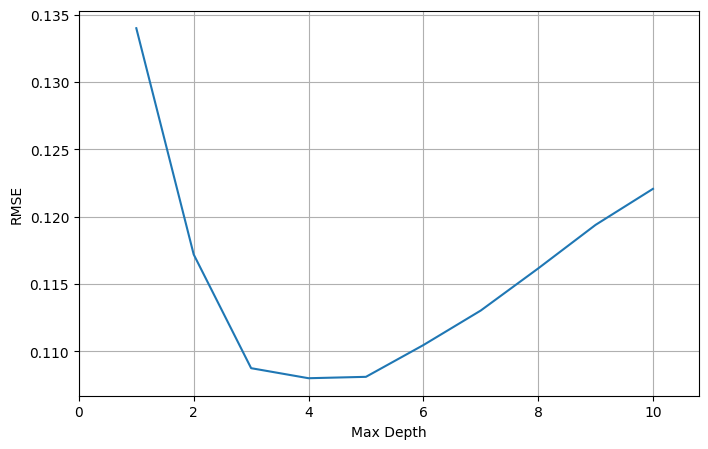

In [58]:
# Plot result
plt.figure(figsize = (8,5))
plt.plot(max_depths, rms_depth)
plt.xlabel('Max Depth')
plt.ylabel('RMSE')
plt.xlim(0, 10.8)
plt.savefig("Decision_tree.png")
plt.grid()

In [33]:
# Re run with max depth = 4
numLoops = 500

rms_error = np.zeros( numLoops )

for idx in range( 0, numLoops ):
  X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2 )
  model = DecisionTreeRegressor( max_depth= 4 )
  model.fit( X_train, y_train )
  y_pred = model.predict( X_test )
  rms_error[idx] = np.sqrt( mean_squared_error( y_test, y_pred ) )

print(f"CV RMSE: {rms_error.mean()*100}")

CV RMSE: 10.796444937489445


### Visualize Desition Tree

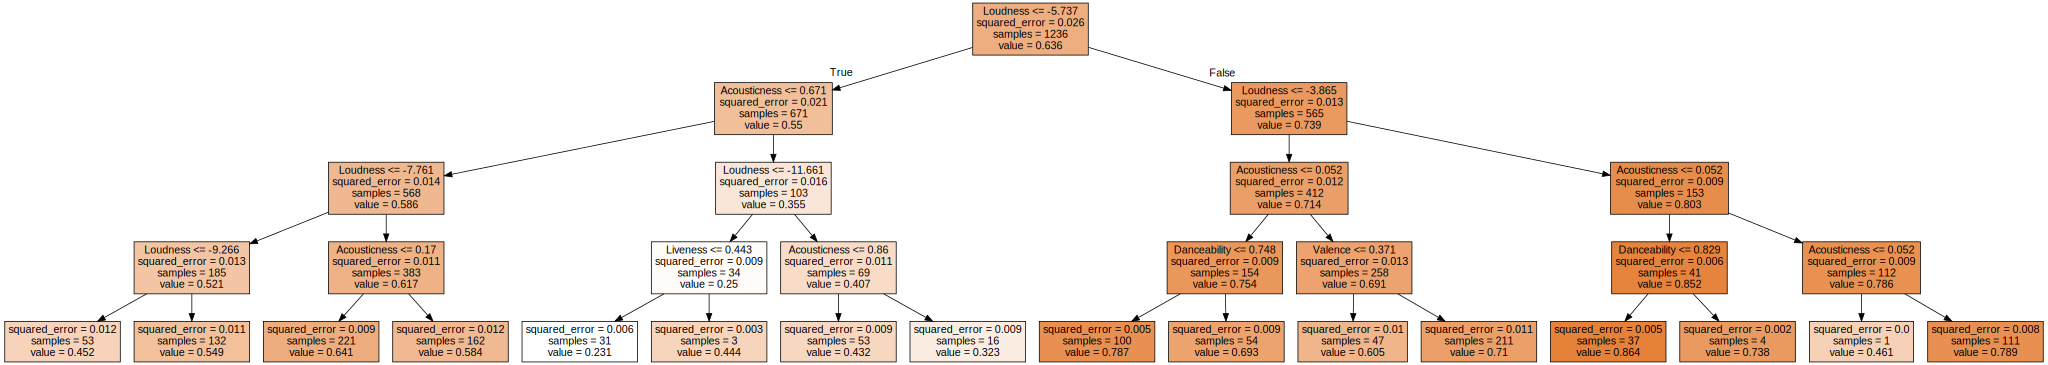

In [34]:
display(
  graphviz.Source(
    tree.export_graphviz(
      model,
      feature_names = X.columns,
      filled = True,
    )
  )
)

## Random Forest

In [35]:
# two parameters - n_estimators (number of trees), max_depth (number of splits)
numLoops = 500

mean_error = np.zeros(numLoops)

# np.random.seed(42)
for idx in range(0,numLoops):
  X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.2 )
  model = RandomForestRegressor( n_estimators = 10 ) #n_estimators is number of trees in forest. Note: you can also choose max_depth for RFs
  model.fit( X_train, y_train )
  y_pred = model.predict( X_test )
  mean_error[idx] = mean_squared_error( y_test, y_pred )

print(f'RMSE: {np.sqrt(mean_error).mean()*100}')
print(f'RMSE_std: {np.sqrt(mean_error).std()*100}')
np.sqrt(mean_error)[:50]

RMSE: 10.061420013549197
RMSE_std: 0.4326519445540144


array([0.10559517, 0.09682729, 0.10089567, 0.09566406, 0.10007326,
       0.09874981, 0.10039877, 0.10524815, 0.10370536, 0.09891934,
       0.10200575, 0.09596211, 0.10565108, 0.10118126, 0.10402805,
       0.10120498, 0.09305567, 0.0951504 , 0.09482048, 0.10179386,
       0.09446038, 0.10002333, 0.10201728, 0.10717497, 0.09997757,
       0.10513079, 0.1067165 , 0.09474354, 0.09952708, 0.09809613,
       0.09365877, 0.10062573, 0.10259885, 0.09146922, 0.10537201,
       0.10167337, 0.09460234, 0.10150914, 0.10871143, 0.09573752,
       0.0943407 , 0.09769035, 0.10496059, 0.09943042, 0.10526906,
       0.08899638, 0.10196944, 0.10050104, 0.10099316, 0.09223433])

### Number of Trees

In [36]:
num_trees = range(10,70,10)
cv_loops = 100
rmse_results = np.zeros(len(num_trees))
std_results = np.zeros(len(num_trees))

for n, trees in enumerate(num_trees):
  rmse_cv = np.zeros(cv_loops)
  np.random.seed(42)
  for i in range(cv_loops):
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20)
    rfModel = RandomForestRegressor( n_estimators=trees )
    rfModel.fit(X_train, y_train)
    y_pred_rf = rfModel.predict(X_test)
    rmse_cv[i] = np.sqrt(mean_squared_error(y_test, y_pred_rf))

  print(trees,' trees finished.')
  rmse_results[n] = rmse_cv.mean()
  std_results[n] = rmse_cv.std()


10  trees finished.
20  trees finished.
30  trees finished.
40  trees finished.
50  trees finished.
60  trees finished.


In [37]:
pickle.dump(rfModel, open('rfModel.p','wb')) # Here we serealize the data

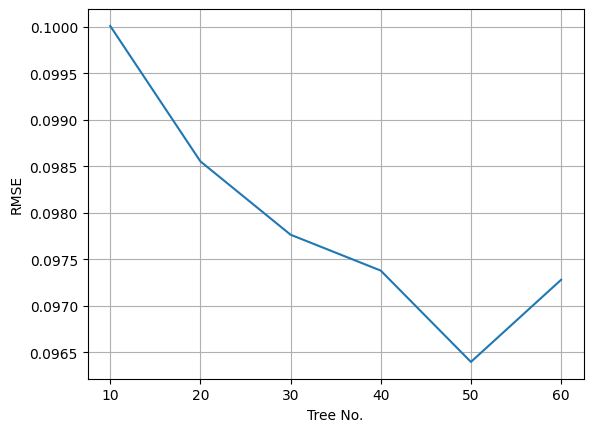

In [38]:
plt.plot(num_trees, rmse_results)
plt.xlabel('Tree No.')
plt.ylabel('RMSE')
plt.savefig("Random_forest.png")

plt.grid()

In [39]:
pd.DataFrame( zip( rmse_results, std_results, ) )

,0,1
0,0.100009,0.004244
1,0.098552,0.004030
2,0.097764,0.003902
3,0.097378,0.003694
4,0.096395,0.004050
5,0.097279,0.004030


In [40]:
print(f'RMSE with 50 trees: {rmse_results[4]*100}')

RMSE with 50 trees: 9.639543408784657


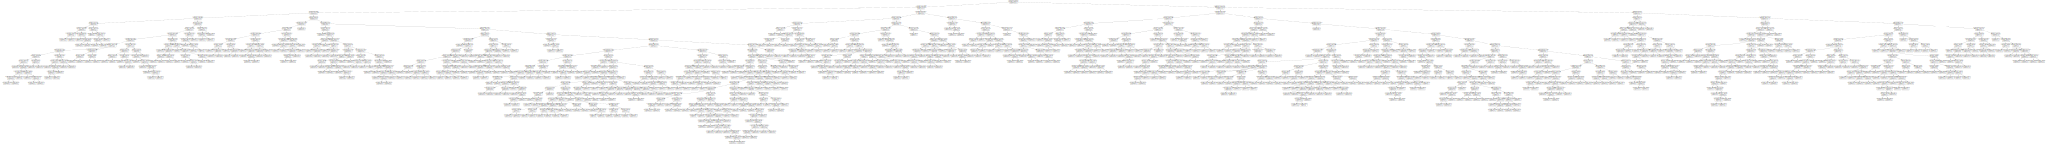

In [41]:
display(
  graphviz.Source(
    tree.export_graphviz(
      rfModel.estimators_[0],
      feature_names = X.columns,
    )
  )
)

### Important Predictors

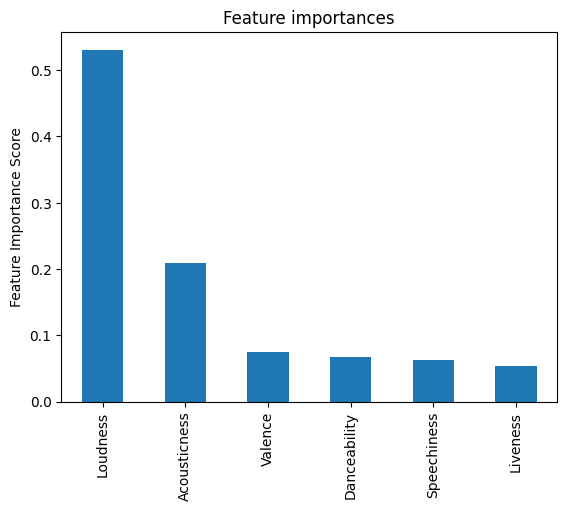

In [42]:
importances = rfModel.feature_importances_
forest_importances = pd.Series( importances, index = X.columns ) # We will apply the feature importance to our serialization

plt.figure()
# forest_importances.plot.bar()
forest_importances.sort_values( ascending = False ).plot.bar()
plt.title("Feature importances")
plt.savefig("important_features.png")
plt.ylabel('Feature Importance Score') ;

## XGBoost

Model without parameters

In [43]:
numLoops = 100
mse_xgb  = np.zeros(numLoops)

for idx in range(0,numLoops):
  X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15)
  xgbr = xgb.XGBRegressor(objective ='reg:squarederror', verbosity=0, seed = 10)
  xgbr.fit(X_train,y_train)
  y_pred_xgb = xgbr.predict(X_test)
  mse_xgb[idx] = mean_squared_error(y_test,y_pred_xgb)


print(f'RMSE: {np.sqrt(mse_xgb).mean()*100}')

RMSE: 10.069944380316482


In [44]:
y_pred_xgb[0]

0.6529742

In [45]:
y_test.to_numpy()[0]

0.528

In [46]:
my_music = X_test[:3]
my_music

,Danceability,Loudness,Speechiness,Acousticness,Liveness,Valence
178,0.933,-6.472,0.162,0.1120,0.1630,0.756
662,0.635,-4.291,0.040,0.0156,0.1180,0.912
1449,0.845,-8.206,0.216,0.1880,0.0806,0.545


In [47]:
xgbr.predict(my_music)

array([0.6529742 , 0.8104844 , 0.55427825], dtype=float32)

In [48]:
y_test[:3]

,Energy
178,0.528
662,0.870
1449,0.631


## XGBoost with Parameters

Let's take it an step further and see if we can improve the model adding some parameters

In [49]:
# Specify the parameters you want to try and their ranges.
param_test = {
 'max_depth'     : [ 3, 4, 5, 6, 7 ],
 'learning_rate' : [ 0.1, 0.2, 0.3, 0.4 ],
 'n_estimators'  : [ 20, 40, 60, 80, 100, 120, 140 ],
}

# Perform the grid search
gsearch = GridSearchCV(
    estimator = xgb.XGBRegressor( objective = 'reg:squarederror', seed = 10 ),
    param_grid = param_test,
    scoring = 'neg_mean_squared_error',
    cv = 5,
)

# Fit to training data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.05, random_state = 42 )
model = gsearch.fit(X_train,y_train)

# See grid search results
print(model.best_params_)

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 60}


We will fit the model with the best parameter

In [50]:
mse_xgb  = np.zeros(numLoops)

for idx in range(0,numLoops):
  X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.15 )
  xgbr = xgb.XGBRegressor(
      objective ='reg:squarederror',
      verbosity=0,
      learning_rate = 0.1, # Including 0.1 learning rate
      max_depth = 3, # Max depth of 3
      n_estimators = 100,
      seed = 10,
  )
  xgbr.fit(X_train,y_train)
  y_pred_xgb = xgbr.predict(X_test)
  mse_xgb[idx] = mean_squared_error(y_test,y_pred_xgb)

print(f'RMSE: {np.sqrt(mse_xgb).mean()*100}')

RMSE: 9.574524943725347


<ipython-input-51-e2921beec3c7>:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels( ax.get_xticklabels(), rotation = 90 )


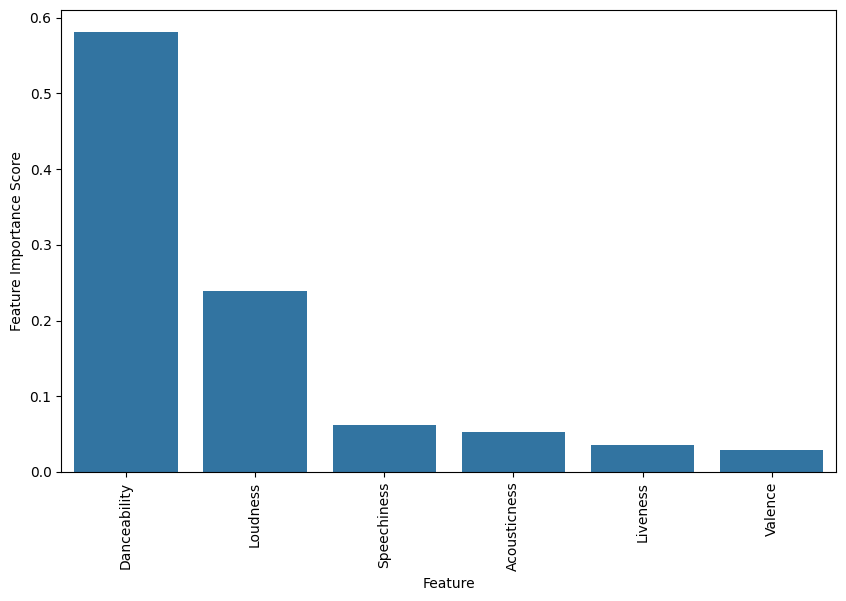

In [51]:
feat_imp = pd.Series(xgbr.feature_importances_, index=X.columns)
plt.figure(figsize = (10,6))
# ax = sns.barplot(x = feat_imp.index, y = feat_imp.values)
ax = sns.barplot(x = feat_imp.index, y = feat_imp.sort_values( ascending = False ).values )
ax.set_xticklabels( ax.get_xticklabels(), rotation = 90 )
plt.savefig("XGboost.png")
plt.xlabel('Feature')
plt.ylabel('Feature Importance Score') ;


In [52]:
(feat_imp.sort_values( ascending = False )*100).cumsum()

,0
Loudness,58.112762
Acousticness,81.969711
Valence,88.155296
Danceability,93.413223
Speechiness,97.037231
Liveness,100.000000


## Visualization

Decision tree plot which we have an RMSE of 10.8

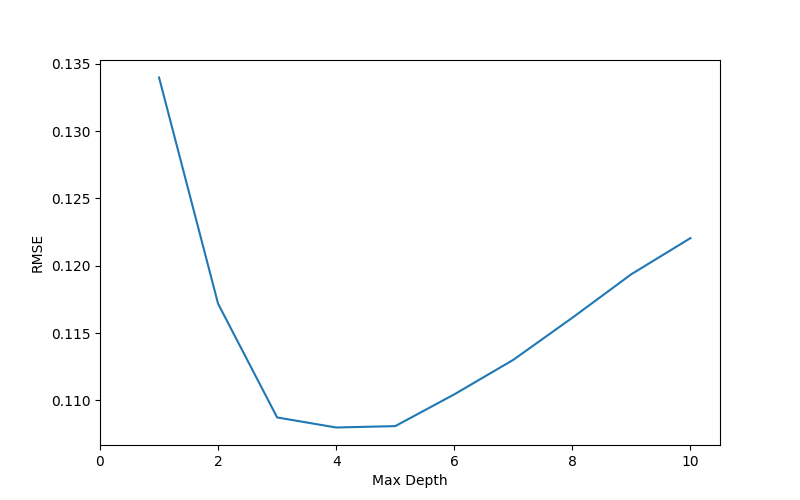

In [53]:
Image("Decision_tree.png")

With Random Forest we got an RMSE of 9.6

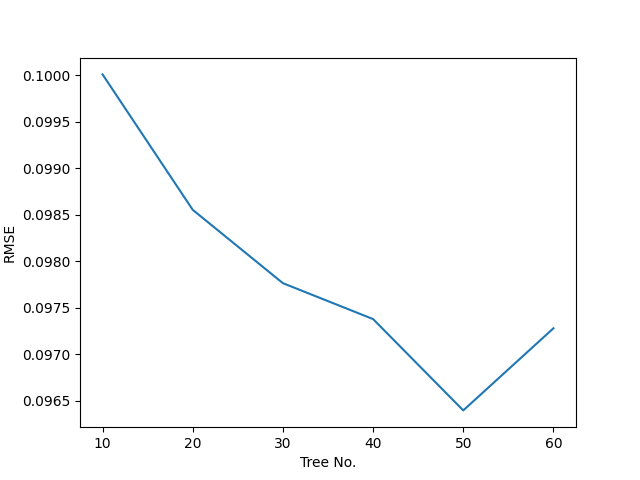

In [54]:
Image("Random_forest.png")

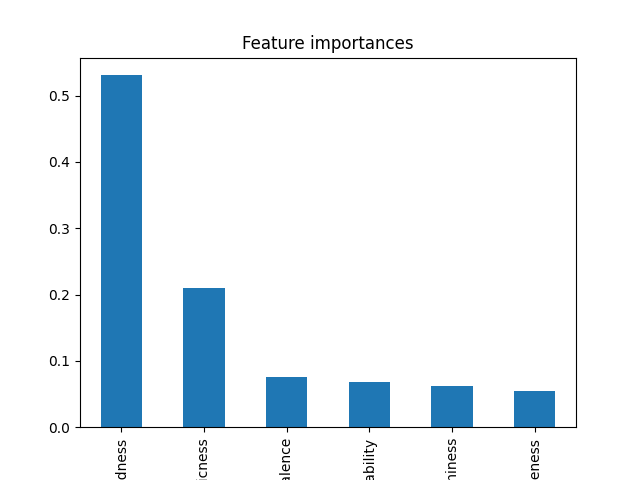

In [55]:
Image("important_features.png")

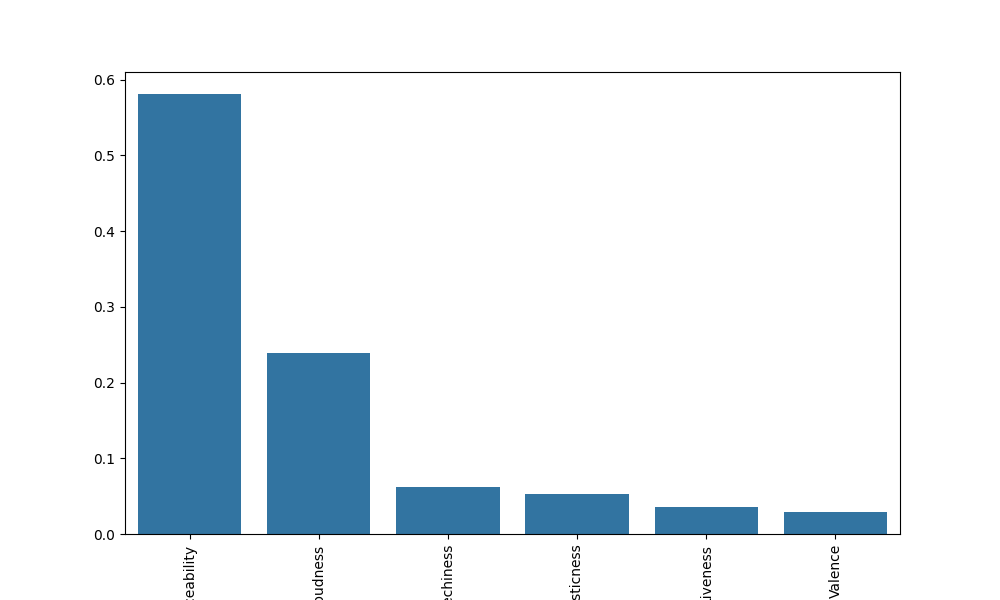

In [56]:
Image("XGboost.png")

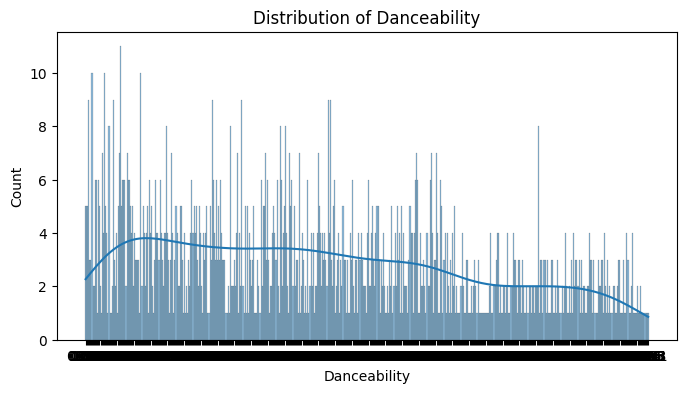

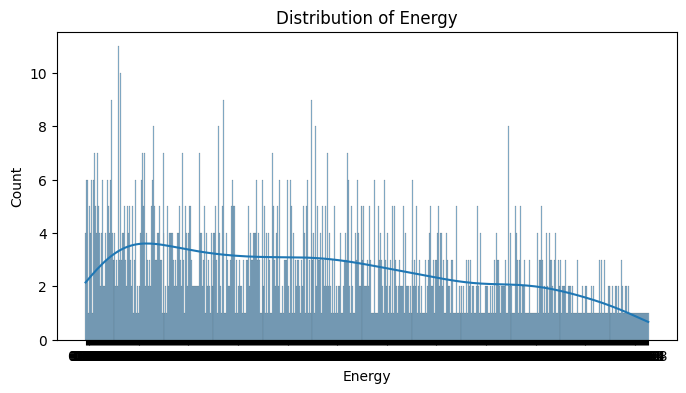

In [57]:
import seaborn as sns
# List of features to plot
features_to_plot = ['Danceability', 'Energy']
# Plot the distribution of each feature
for feature in features_to_plot:
    plt.figure(figsize=(8, 4))
    sns.histplot(spotify[feature], kde=True)
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.show()

## Clonclusion & Future considerations

After cleaning our dataset and selecting the features with highest importancy, we can say that:

- Listeners prefer songs they can dance to, with positive lyrics, good energy, clear delivery in the speech and considerably good acousticness and volume. Just like the song "Beggin' by Måneskin"

- Pop seems to be the genre that listener prefer at least during the years 2020 and 2021. of couse this is not the most important feature to pay attention to, but it's definitely something to keep in mind for comercial purposes.


- Even thought listeners will pick their favorite songs depending on the features we described before, there is an slight correlation with the artist followers which reinforces the fact that marketing and management are still key for an artist success.

- Our model XGBoost showed to be the strongest model showing a Root Square Mean Error of (9.5)

- In the future we would like to see more data about other platforms, more historic data and make an analysis focused on outliers meaning artist that have had great success without as many followers.

- Analyze how genre preferences have changed over time to identify emerging trends.

- Investigate how different genres are combined to create popular songs (e.g., Pop-Rock, Indie-Pop).

- Compare music trends in different regions to identify global and local preferences.